# Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import random

# For reproducability.
seed = 2003
random.seed(seed)
np.random.seed(seed)

# Import Datasets

In [207]:
assessments = pd.read_csv(r'..\..\anonymisedData\assessments.csv')
courses = pd.read_csv(r'..\..\anonymisedData\courses.csv')
studentAssessment = pd.read_csv(r'..\..\anonymisedData\studentAssessment.csv')
studentInfo = pd.read_csv(r'..\..\anonymisedData\studentInfo.csv')
studentRegistration = pd.read_csv(r'..\..\anonymisedData\studentRegistration.csv')
studentVle = pd.read_csv(r'..\..\anonymisedData\studentVle.csv')
vle = pd.read_csv(r'..\..\anonymisedData\vle.csv')

# Defined Functions

In [208]:
def compare_df_cols(series1, series2):
    """
    Compare two pandas Series and identify values present in series1 but missing in series2.
    Counts how many times each missing value appears in series1.
    
    Args:
        series1 (pd.Series): The first series to compare (e.g., list of student IDs from registration).
        series2 (pd.Series): The second series to compare against (e.g., list of student IDs from assessment).
    
    Prints:
        Total number of missing rows (values in series1 not found in series2).
        Number of unique missing values.
        The missing values along with their occurrence counts in series1.

    Returns:
        missing_counts (pd.Series): A series containing the missing values from series1 as the index and their counts as the values.
    """
    missing_values = series1[~series1.isin(series2)] # Find values in series1 not in series2.
    missing_counts = missing_values.value_counts() # Count how many times each missing ID appears.

    print(f'Total missing rows: {missing_counts.sum()}') # Total rows missing.
    print(f'Number of unique missing IDs: {len(missing_counts)}')  # Unique missing IDs.
    print('Missing IDs and their counts:')
    print(missing_counts)

    return missing_counts

def plot_bar_with_annotations(categories, counts, xlabel='', ylabel='', title='', rotation=0, color='skyblue', figsize=(8,5)):
    """
    Plots a bar chart with annotations on top of each bar.
    
    Args:
        categories (list): Categories/labels for the x-axis.
        counts (list): Corresponding counts or values for each category.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Plot title.
        rotation (int): Rotation angle for x-axis tick labels.
        color (str or list): Bar color(s).
        figsize (tuple): Figure size (width, height).
    """
    plt.figure(figsize=figsize)
    bars = plt.bar(categories, counts, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=rotation)
    
    # Add annotations on top of each bar.
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset.
                     textcoords="offset points",
                     ha='center', va='bottom')
    plt.show()

def compare_shared_columns(df1, df2, name1='df1', name2='df2', return_missing=False):
    """
    For each shared column between two DataFrames:
    - Show how many values in df1[col] are found in df2[col] using .isin().value_counts().
    - Show what unique values in df1[col] do not appear in df2[col].
    - Optionally return a dictionary of DataFrames with rows from df1 that contain those missing values.
    
    Args:
        df1, df2 (pd.DataFrame): DataFrames to compare.
        name1, name2 (str): Names to use in output for readability.
        return_missing (bool): If True, returns a dict of DataFrames showing rows from df1 with unmatched values.
    
    Returns:
        missing_rows (dict): Optional. Keys are column names, values are DataFrames of missing rows in df1.
    """
    shared_cols = set(df1.columns) & set(df2.columns)
    print(f'Shared columns between {name1} and {name2}: {shared_cols}\n')

    missing_rows = {}

    for col in sorted(shared_cols):
        print(f'=== Column: "{col}" ===')

        # 1. Value presence check
        match_mask = df1[col].isin(df2[col])
        print(f'Presence of {name1} values in {name2}:')
        print(match_mask.value_counts(), '\n')

        # 2. Unique value difference
        df1_unique = set(df1[col].dropna().unique())
        df2_unique = set(df2[col].dropna().unique())
        missing_values = df1_unique - df2_unique

        print(f'Values from {name1} not in {name2}: {missing_values}')
        print(f'Number of missing values: {len(missing_values)}\n')

        # 3. Return missing rows from df1, if requested
        if return_missing and missing_values:
            missing_df = df1[df1[col].isin(missing_values)].copy()
            missing_rows[col] = missing_df

    if return_missing:
        return missing_rows

def get_missing_rows(df1, df2, col):
    """
    Return all rows from df1 where values in 'col' do not appear in df2[col].
    """
    # Get unique values from each dataframe column (excluding NaNs).
    unique_vals_df1 = df1[col].dropna().unique()
    unique_vals_df2 = df2[col].dropna().unique()

    # Identify values in df1[col] missing from df2[col].
    missing_values = [val for val in unique_vals_df1 if val not in unique_vals_df2]

    # Filter df1 rows where column value is in the missing_values list.
    missing_rows = df1[df1[col].isin(missing_values)].copy()

    return missing_rows

# Overview and Analyse Dataset

## Courses Table

This table provides a list of all modules and their corresponding presentations. It includes the following columns:

* **code\_module**: the identifier for each module.
* **code\_presentation**: the identifier for each presentation, combining the year with either "B" (for February starts) or "J" (for October starts).
* **length**: the duration of the module presentation in days.

Since the structure of B and J presentations may vary, it is advisable to analyse them separately. However, in some cases, one type of presentation (B or J) may not have a counterpart from the previous cycle. In such instances, specifically for the CCC, EEE, and GGG modules, the available J presentation may need to be used to inform the B presentation, or vice versa.

In [209]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


### Missing, Duplicate, and Distinct Values Overview

In [210]:
print('Total null values: \n', courses.isnull().sum(), '\n')
print('Total duplicated values:', courses[courses.duplicated()], '\n')
print('Total unique values: \n', courses.nunique())

Total null values: 
 code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, module_presentation_length]
Index: [] 

Total unique values: 
 code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64


### Data Types and Schema Overview

In [211]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 660.0+ bytes


## Assessments Table

This table contains details about assessments associated with different module presentations. Each presentation generally includes several assessments and concludes with a final exam. The CSV table includes the following columns:

* **code\_module**: The identifier for the module to which the assessment belongs.
* **code\_presentation**: The identifier for the specific presentation of the module.
* **id\_assessment**: A unique identifier for each assessment.
* **assessment\_type**: The category of the assessment, which can be one of the following: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA), or Final Exam (Exam).
* **date**: The submission deadline for the assessment, expressed as the number of days from the start of the presentation (which begins at day 0).
* **weight**: The contribution of the assessment to the overall module grade, given as a percentage. Exams typically carry a separate weight of 100%, while the combined weight of all other assessments is also 100%. If the exam date is not provided, it is assumed to occur at the end of the final presentation week.

In [212]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


### Missing, Duplicate, and Distinct Values Overview

In [213]:
print('Total null values: \n', assessments.isnull().sum(), '\n')
print('Total duplicated values:', assessments[assessments.duplicated()], '\n')
print('Total unique values: \n', assessments.nunique())

Total null values: 
 code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, id_assessment, assessment_type, date, weight]
Index: [] 

Total unique values: 
 code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  74
weight                24
dtype: int64


There are 11 assessments with missing submission dates. The dataset includes:

* **7 distinct modules**
* **4 different presentations**: 2013J, 2013B, 2014J, and 2014B. The year indicates when the presentation took place, while "B" represents a February start and "J" an October start.
* **A total of 206 assessments** distributed across all modules
* **3 types of assessments**: Tutor Marked Assessments (TMA), Computer Marked Assessments (CMA), and Final Exams (Exam)

### Data Types and Schema Overview

In [214]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


The `id_assessment` values are currently displayed as integers, which is inaccurate. We should convert them to the `object` data type instead.

In [215]:
assessments['id_assessment'] = assessments['id_assessment'].astype(object)

### Investigate Assessment Weights

Project brief states that typically, exams have a weight of 100 and the sum of all other assessments is 100. This would man that a module with one exam only would have a weight of 100 and a module with one exam and some assessments would have a weight of 200. Let’s check if this so in the table provided.


In [216]:
# Group by module presentation and sum the weights of assessments.
assessments.groupby(['code_module','code_presentation']).agg(total_weight = ('weight', 'sum'))

total_weight
code_module code_presentation              
AAA         2013J                     200.0
            2014J                     200.0
BBB         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
CCC         2014B                     300.0
            2014J                     300.0
DDD         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
EEE         2013J                     200.0
            2014B                     200.0
            2014J                     200.0
FFF         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
GGG         2013J                     100.0
            2014B                     100.0
            2014J                     100.0

We observe that most module presentations have a total assessment weight of 200. However, there are exceptions like module CCC has a total weight of 300, while module GGG has only 100. Let us examine these cases more closely.

Let us start with the 'Exam' assessment type

In [217]:
# Examine the weight distribution of 'exams' across different module presentations.
assessments[assessments['assessment_type'] == 'Exam'].groupby(['code_module','code_presentation', 'assessment_type']).agg(total_weight = ('weight', 'sum'))

total_weight
code_module code_presentation assessment_type              
AAA         2013J             Exam                    100.0
            2014J             Exam                    100.0
BBB         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
CCC         2014B             Exam                    200.0
            2014J             Exam                    200.0
DDD         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
EEE         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
FFF         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
GGG         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0

All modules have an exam weight of 100, except for module CCC (in both presentations). Let us now count how many exam assessments exist in each module presentation.


In [218]:
# Count how many exams there are in every module and presentation.
assessments[assessments['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']].groupby(['code_module', 'code_presentation']).count()

id_assessment
code_module code_presentation               
AAA         2013J                          1
            2014J                          1
BBB         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
CCC         2014B                          2
            2014J                          2
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
EEE         2013J                          1
            2014B                          1
            2014J                          1
FFF         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
GGG         2013J                          1
            2014B                          1
            2014J                          1

Module CCC includes two exams, which likely explains the higher total assessment weight for this module. Now, let us examine all the assignments that are not classified as exams to ensure everything appears correct.

In [219]:
# Calculate the total weight of all non-exam assignments for each module and presentation.
assessments[assessments['assessment_type'] != 'Exam'].groupby(['code_module', 'code_presentation']).agg(total_weight = ('weight', 'sum'))

total_weight
code_module code_presentation              
AAA         2013J                     100.0
            2014J                     100.0
BBB         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
CCC         2014B                     100.0
            2014J                     100.0
DDD         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
EEE         2013J                     100.0
            2014B                     100.0
            2014J                     100.0
FFF         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
GGG         2013J                       0.0
            2014B                       0.0
            2014J                       0.0

We observe that module GGG has no assignment weight. Let us investigate further.

In [220]:
assessments[assessments['code_module'] == 'GGG'].groupby(['code_module','code_presentation', 'assessment_type']).agg(weight_by_type = ('weight', 'sum'))

weight_by_type
code_module code_presentation assessment_type                
GGG         2013J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014B             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0

Module GGG has both CMA and TMA, but both have zero weight. Let us check if there are any other modules besides GGG where CMA or TMA have zero weight.

In [221]:
assessments[(assessments['assessment_type'] == 'TMA') & (assessments['weight'] == 0)]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
48,BBB,2014J,15020,TMA,19.0,0.0
182,GGG,2013J,37415,TMA,61.0,0.0
183,GGG,2013J,37416,TMA,124.0,0.0
184,GGG,2013J,37417,TMA,173.0,0.0
192,GGG,2014B,37425,TMA,61.0,0.0
193,GGG,2014B,37426,TMA,117.0,0.0
194,GGG,2014B,37427,TMA,166.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [222]:
assessments[(assessments['assessment_type'] == 'CMA') & (assessments['weight'] == 0)]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
124,FFF,2013B,34865,CMA,222.0,0.0
125,FFF,2013B,34866,CMA,222.0,0.0
126,FFF,2013B,34867,CMA,222.0,0.0
127,FFF,2013B,34868,CMA,222.0,0.0
128,FFF,2013B,34869,CMA,222.0,0.0
129,FFF,2013B,34871,CMA,222.0,0.0
130,FFF,2013B,34870,CMA,222.0,0.0
137,FFF,2013J,34878,CMA,236.0,0.0
138,FFF,2013J,34879,CMA,236.0,0.0
139,FFF,2013J,34880,CMA,236.0,0.0


It appears that the FFF modules have CMAs with zero weight, while for the BBB module, only the 2014b presentation has a TMA assessment with zero weight.

## Student Assessment Table

This table records the results of students' assessments. If a student does not submit an assessment, no result is captured. Similarly, final exam data is missing if the assessment result was not recorded in the system. The table includes the following columns:

* **id\_assessment**: unique identifier for the assessment.
* **id\_student**: unique identifier for each student.
* **date\_submitted**: the number of days since the start of the module presentation when the student submitted the assessment.
* **is\_banked**: a flag indicating whether the result was carried over from a previous presentation.
* **score**: the student’s score for the assessment, ranging from 0 to 100. Scores below 40 are considered a fail.

In [223]:
studentAssessment.head(10)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
5,1752,45462,20,0,70.0
6,1752,45642,18,0,72.0
7,1752,52130,19,0,72.0
8,1752,53025,9,0,71.0
9,1752,57506,18,0,68.0


In [224]:
studentAssessment.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


### Missing, Duplicate, and Distinct Values Overview

In [225]:
print('Total null values: \n', studentAssessment.isnull().sum(), '\n')
print('Total duplicated values:', studentAssessment[studentAssessment.duplicated()], '\n')
print('Total unique values: \n', studentAssessment.nunique())

Total null values: 
 id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [id_assessment, id_student, date_submitted, is_banked, score]
Index: [] 

Total unique values: 
 id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64


There are 173 null scores and no duplicated data

### Data Types and Schema Overview

In [226]:
studentAssessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [227]:
studentAssessment['id_assessment'] = studentAssessment['id_assessment'].astype(object)
studentAssessment['id_student'] = studentAssessment['id_student'].astype(object)

Convert the ID fields as object

### Submission Issue

In [228]:
assessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [229]:
# Find id_assessment values that are in assessments but not in studentAssessment.
missing_assessment_ids = assessments[~assessments['id_assessment'].isin(studentAssessment['id_assessment'])]

# Extract module and presentation for those missing ids.
missing_modules = missing_assessment_ids[['id_assessment', 'code_module', 'code_presentation', 'assessment_type']].drop_duplicates()

print("Assessments missing in studentAssessment:")
print(missing_modules)


Assessments missing in studentAssessment:
    id_assessment code_module code_presentation assessment_type
5            1757         AAA             2013J            Exam
11           1763         AAA             2014J            Exam
23          14990         BBB             2013B            Exam
35          15002         BBB             2013J            Exam
47          15014         BBB             2014B            Exam
53          15025         BBB             2014J            Exam
63          40087         CCC             2014B            Exam
73          40088         CCC             2014J            Exam
113         30713         EEE             2013J            Exam
118         30718         EEE             2014B            Exam
123         30723         EEE             2014J            Exam
136         34872         FFF             2013B            Exam
149         34885         FFF             2013J            Exam
162         34898         FFF             2014B            Exa

There are 18 assessments missing from the `studentAssessment` table, all of which are of the "Exam" type. The only module for which exam data is fully present in the `studentAssessment` table is module DDD.


In [230]:
studentAssessment[studentAssessment['score'].isnull()]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


We also have 173 rows with null scores. According to the data description, if a student does not submit an assessment, no result is recorded. Similarly, final exam entries are absent when the assessment results are not stored in the system. As such, any missing scores can be interpreted as non-submissions.

**However, it's somewhat strange that some entries with missing scores still have submission dates recorded. Typically, if an assessment hasn't been submitted, the submission date should also be missing. This inconsistency should ideally be clarified with the data providers.**

## Student Registration Table

This table captures the timing of student registrations for module presentations. For students who withdrew, the date of unregistration is also included. It contains five columns:

* **code\_module**: the module's identification code.
* **code\_presentation**: the presentation's identification code.
* **id\_student**: a unique identifier for each student.
* **date\_registration**: the number of days (relative to the start of the module presentation) when the student registered. A negative value (e.g., -30) indicates registration occurred before the presentation began.
* **date\_unregistration**: the number of days (relative to the start of the module presentation) when the student withdrew. This field is empty for students who completed the course. Those who withdrew are marked with "Withdrawal" in the `final_result` column of the `studentInfo.csv` table.


In [231]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [232]:
studentRegistration.describe()

,id_student,date_registration,date_unregistration
count,3.259300e+04,32548.000000,10072.000000
mean,7.066877e+05,-69.411300,49.757645
std,5.491673e+05,49.260522,82.460890
min,3.733000e+03,-322.000000,-365.000000
25%,5.085730e+05,-100.000000,-2.000000
50%,5.903100e+05,-57.000000,27.000000
75%,6.444530e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


### Missing, Duplicate, and Distinct Values Overview

In [233]:
print('Total null values: \n', studentRegistration.isnull().sum(), '\n')
print('Total duplicated values:', studentRegistration[studentRegistration.duplicated()], '\n')
print('Total unique values: \n', studentRegistration.nunique())

Total null values: 
 code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, id_student, date_registration, date_unregistration]
Index: [] 

Total unique values: 
 code_module                7
code_presentation          4
id_student             28785
date_registration        332
date_unregistration      416
dtype: int64


There are 28,785 unique students in total, but the dataset contains 32,548 records. This suggests that some students may have registered for a particular module or presentation, later deregistered, and either switched to a different module/presentation or retaken the module in a subsequent session.

### Check Date Unregistration

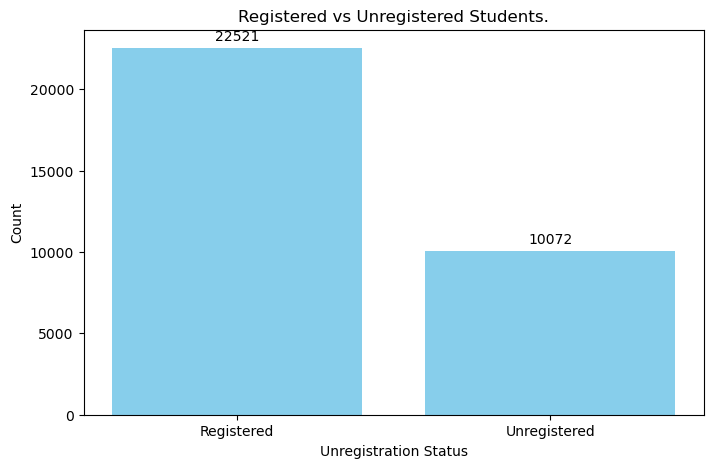

In [234]:
# Calculate missing and non-missing counts for date_unregistration.
missing_date_unreg_count = studentRegistration['date_unregistration'].isna().sum()
non_missing_date_unreg_count = studentRegistration['date_unregistration'].notna().sum()

plot_bar_with_annotations(
    categories=['Registered', 'Unregistered'],
    counts=[missing_date_unreg_count, non_missing_date_unreg_count],
    xlabel='Unregistration Status',
    ylabel='Count',
    title='Registered vs Unregistered Students.',
    rotation=0
)

About 31% (10,072) of the students (non-unique) in this dataset have unregistered.

### Data Types and Schema Overview

In [235]:
studentRegistration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [236]:
studentRegistration['id_student'] = studentRegistration['id_student'].astype(object)

### Missing Student ID Check

Let us see if all student IDs in the `StudentRegistration` tables exist in the `StudentAssessment` table.

In [237]:
# Call the function 'compare_df_cols' with the student IDs series.
compare_df_cols(studentRegistration['id_student'], studentAssessment['id_student'])

Total missing rows: 5847
Number of unique missing IDs: 5416
Missing IDs and their counts:
id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64


id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64

We observe that approximately 5,847 student records are missing from the `StudentAssessment` table, corresponding to 5,416 unique student IDs. Next, let us perform a similar check for the `StudentInfo` table.

In [238]:
compare_df_cols(studentInfo['id_student'], studentAssessment['id_student'])

Total missing rows: 5847
Number of unique missing IDs: 5416
Missing IDs and their counts:
id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64


id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64

Similarly, there are 5,847 student records (5,416 unique students) present in the `StudentInfo` table but missing from the `StudentAssessment` table. Let us continue to investigate this further.

In [239]:
# Get unique id_student.
SR_ID = studentRegistration['id_student'].unique()
SI_ID = studentInfo['id_student'].unique()

# Compare the two lists.
difference = set(SR_ID).difference(set(SI_ID))
difference = len(difference)
difference

0

The missing student IDs across `studentRegistration` and `studentInfo` are the same students

In [240]:
missing_ids = compare_df_cols(studentRegistration['id_student'], studentAssessment['id_student'])

missing_students = studentInfo[studentInfo['id_student'].isin(missing_ids.index)]
missing_students.head(10)

Total missing rows: 5847
Number of unique missing IDs: 5416
Missing IDs and their counts:
id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
44,AAA,2013J,135335,F,East Anglian Region,Lower Than A Level,20-30%,0-35,0,180,N,Withdrawn
118,AAA,2013J,281589,M,North Western Region,HE Qualification,30-40%,0-35,0,60,N,Fail
125,AAA,2013J,292923,F,South East Region,A Level or Equivalent,90-100%,35-55,0,180,N,Withdrawn
136,AAA,2013J,305539,F,Wales,Lower Than A Level,80-90%,0-35,0,120,N,Withdrawn
169,AAA,2013J,346843,F,Scotland,HE Qualification,50-60%,35-55,0,120,N,Fail
171,AAA,2013J,354858,M,South Region,HE Qualification,90-100%,35-55,0,120,N,Withdrawn
198,AAA,2013J,405961,M,Scotland,A Level or Equivalent,90-100%,0-35,0,240,Y,Withdrawn
209,AAA,2013J,494424,F,North Region,A Level or Equivalent,80-90%,0-35,0,60,N,Fail
256,AAA,2013J,1763015,F,Scotland,A Level or Equivalent,10-20,35-55,0,60,N,Withdrawn


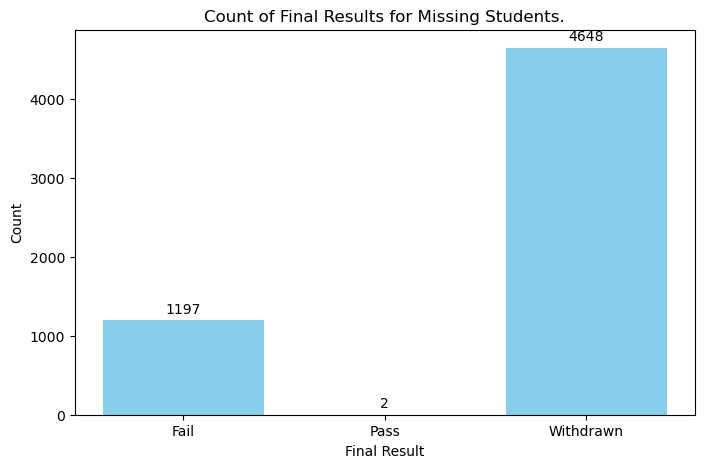

In [241]:
unique, counts = np.unique(missing_students['final_result'], return_counts = True)
dict(zip(unique, counts))

plot_bar_with_annotations(
    categories=unique,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count',
    title='Count of Final Results for Missing Students.',
    rotation=0
)

In [242]:
# Display the missing student with final result as 'Pass'.
missing_students[missing_students['final_result'] == 'Pass']

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
645,AAA,2014J,1336190,M,London Region,HE Qualification,80-90%,55<=,0,60,N,Pass
12893,CCC,2014J,1777834,F,East Anglian Region,A Level or Equivalent,80-90%,35-55,0,60,N,Pass


Most of the missing students have either withdrawn or failed, with only two having passed. This is unusual since there are two students who have no recorded submissions yet are marked as having passed their modules. This likely indicates an error in the dataset.

In [243]:
missing_students_reg = studentRegistration[studentRegistration['id_student'].isin(missing_ids.index)]
missing_students_reg.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration
2,AAA,2013J,30268,-92.0,12.0
44,AAA,2013J,135335,-29.0,30.0
118,AAA,2013J,281589,-50.0,NaN
125,AAA,2013J,292923,-162.0,-121.0
136,AAA,2013J,305539,-54.0,-3.0
169,AAA,2013J,346843,-44.0,NaN
171,AAA,2013J,354858,-32.0,5.0
198,AAA,2013J,405961,-170.0,-100.0
209,AAA,2013J,494424,-38.0,NaN
256,AAA,2013J,1763015,-58.0,-2.0


In [244]:
missing_students_reg['date_unregistration'].notnull().sum()

4594

Another issue with this dataset is the discrepancy in the number of withdrawn students. In the `studentInfo` table, there are 4,648 students marked as withdrawn, whereas in the `studentRegistration` table, the count of students with a non-null `date_unregistration` is 4,594, resulting in a difference of 54 students without an assigned unregistered date.

In [245]:
studentRegistration[studentRegistration['id_student'] == 1336190]

,code_module,code_presentation,id_student,date_registration,date_unregistration
645,AAA,2014J,1336190,-23.0,NaN


In [246]:
studentRegistration[studentRegistration['id_student'] == 1777834]

,code_module,code_presentation,id_student,date_registration,date_unregistration
12893,CCC,2014J,1777834,NaN,NaN


The two students from the missing student list do not have a recorded unregistration date, which means they have not withdrawn.

## Student Info Table

This table provides demographic details about the students along with their academic outcomes. It includes the following columns:

* **code\_module**: A unique code representing the module the student is enrolled in.
* **code\_presentation**: The specific presentation (e.g., semester and year) during which the student is taking the module.
* **id\_student**: A unique identifier for each student.
* **gender**: The gender of the student.
* **region**: The geographic area where the student resided while taking the module.
* **highest\_education**: The highest level of education the student had completed upon starting the module.
* **imd\_band**: The Index of Multiple Deprivation band corresponding to the student's place of residence during the module.
* **age\_band**: The age range into which the student falls.
* **num\_of\_prev\_attempts**: The number of times the student has previously taken the module.
* **studied\_credits**: The total number of credits the student was enrolled in at the time.
* **disability**: Indicates whether the student declared any disabilities.
* **final\_result**: The final outcome of the student in that module presentation. This column has four categories: `Distinction`, `Pass`, `Fail` and `Withdrawn`.


In [247]:
studentInfo.head(10)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
6,AAA,2013J,45462,M,Scotland,HE Qualification,30-40%,0-35,0,60,N,Pass
7,AAA,2013J,45642,F,North Western Region,A Level or Equivalent,90-100%,0-35,0,120,N,Pass
8,AAA,2013J,52130,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,0,90,N,Pass
9,AAA,2013J,53025,M,North Region,Post Graduate Qualification,NaN,55<=,0,60,N,Pass


In [248]:
studentInfo.describe()

,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


### Missing, Duplicate, and Distinct Values Overview

In [249]:
print('Total null values: \n', studentInfo.isnull().sum(), '\n')
print('Total duplicated values:', studentInfo[studentInfo.duplicated()], '\n')
print('Total unique values: \n', studentInfo.nunique())

Total null values: 
 code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, id_student, gender, region, highest_education, imd_band, age_band, num_of_prev_attempts, studied_credits, disability, final_result]
Index: [] 

Total unique values: 
 code_module                 7
code_presentation           4
id_student              28785
gender                      2
region                     13
highest_education           5
imd_band                   10
age_band                    3
num_of_prev_attempts        7
studied_credits            61
disability                  2
final_result                4
dtype:

There are 1,111 entries where the *imd\_band* information is missing. Another notable observation is that although there are 32,593 student records in total, only around 28,785 of them represent unique students. This indicates that some student IDs appear multiple times, likely because those students switched to different modules or presentations.

### Data Types and Schema Overview

In [250]:
studentInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [251]:
studentInfo['id_student'] = studentInfo['id_student'].astype(object)

## VLE Table

The table provides details about the materials available in the Virtual Learning Environment (VLE). These materials typically include HTML pages, PDF documents, and similar resources. Students can access these materials online, and their interactions with them are tracked. The table contains the following columns:

* **id\_site**: a unique identifier for each material.
* **code\_module**: the code representing the module.
* **code\_presentation**: the code representing the presentation.
* **activity\_type**: the role or type associated with the module material.
* **week\_from**: the starting week when the material is intended to be used.
* **week\_to**: the ending week until which the material is planned to be available.


In [252]:
vle.head(10)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
5,546614,AAA,2013J,homepage,NaN,NaN
6,546897,AAA,2013J,url,NaN,NaN
7,546678,AAA,2013J,oucontent,NaN,NaN
8,546933,AAA,2013J,resource,NaN,NaN
9,546708,AAA,2013J,oucontent,NaN,NaN


### Missing, Duplicate, and Distinct Values Overview

In [253]:
print('Total null values: \n', vle.isnull().sum(), '\n')
print('Total duplicated values:', vle[vle.duplicated()], '\n')
print('Total unique values: \n', vle.nunique())

Total null values: 
 id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [id_site, code_module, code_presentation, activity_type, week_from, week_to]
Index: [] 

Total unique values: 
 id_site              6364
code_module             7
code_presentation       4
activity_type          20
week_from              30
week_to                30
dtype: int64


### Data Types and Schema Overview

In [254]:
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [255]:
vle['id_site'] = vle['id_site'].astype(object)

### Check for Missing Week Data.

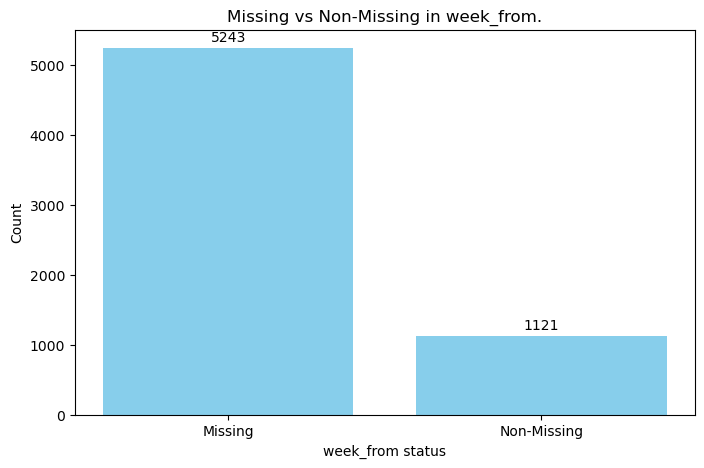

In [256]:
# Calculate missing and non-missing counts for week_from.
missing_count = vle['week_from'].isna().sum()
non_missing_count = vle['week_from'].notna().sum()

plot_bar_with_annotations(
    categories=['Missing', 'Non-Missing'],
    counts=[missing_count, non_missing_count],
    xlabel='week_from status',
    ylabel='Count',
    title='Missing vs Non-Missing in week_from.',
    rotation=0
)

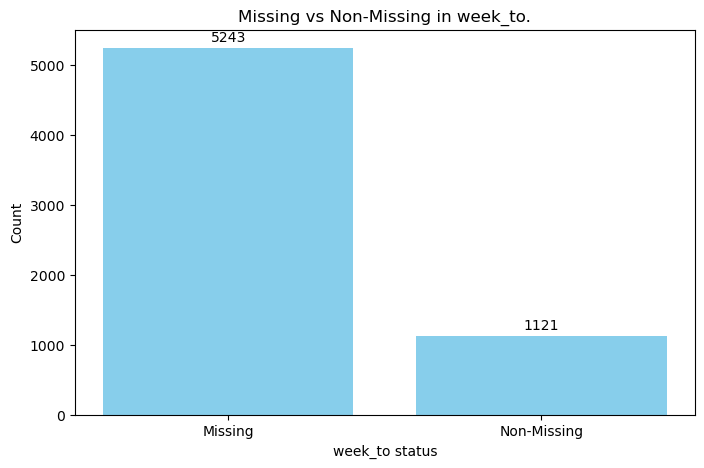

In [257]:
# Calculate missing and non-missing counts for week_to.
missing_count = vle['week_to'].isna().sum()
non_missing_count = vle['week_to'].notna().sum()

plot_bar_with_annotations(
    categories=['Missing', 'Non-Missing'],
    counts=[missing_count, non_missing_count],
    xlabel='week_to status',
    ylabel='Count',
    title='Missing vs Non-Missing in week_to.',
    rotation=0
)

A vast majority of the week data is missing from the `vle` table (about 82% missing).

## Student VLE Table

The `studentVle` table records how students interact with online learning materials available in the VLE. It includes the following columns:

* **code\_module**: A code identifying the module.
* **code\_presentation**: A code identifying the specific presentation of the module.
* **id\_student**: A unique ID assigned to each student.
* **id\_site**: A unique ID for each VLE resource or material.
* **date**: The day (relative to the module's start date) on which the interaction occurred.
* **sum\_click**: The total number of times the student interacted with the material on that particular day.


In [258]:
studentVle.head(10)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
5,AAA,2013J,28400,546652,-10,8
6,AAA,2013J,28400,546876,-10,2
7,AAA,2013J,28400,546688,-10,15
8,AAA,2013J,28400,546662,-10,17
9,AAA,2013J,28400,546890,-10,1


### Missing, Duplicate, and Distinct Values Overview

In [259]:
print('Total null values: \n', studentVle.isnull().sum(), '\n')
print('Total duplicated values:', studentVle[studentVle.duplicated()], '\n')
print('Total unique values: \n', studentVle.nunique())

Total null values: 
 code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64 

Total duplicated values:          code_module code_presentation  id_student  id_site  date  sum_click
2                AAA             2013J       28400   546652   -10          1
63               AAA             2013J       45462   546652   -10          1
180              AAA             2013J       77367   546652   -10          4
193              AAA             2013J       94961   546652   -10          2
442              AAA             2013J      248270   546652   -10          4
...              ...               ...         ...      ...   ...        ...
10655235         GGG             2014J      686194   897083   267          1
10655250         GGG             2014J      676071   896939   268          1
10655256         GGG             2014J      642905   896939   268          2
10655261         GGG           

This dataset contains duplicate entries, but it's not a significant concern because students may interact with the VLE multiple times in a single day. Each interaction may be recorded separately, so multiple records for the same student on the same day are expected.

### Data Types and Schema Overview

In [260]:
studentVle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [261]:
studentVle['id_student'] = studentVle['id_student'].astype(object)
studentVle['id_site'] = studentVle['id_site'].astype(object)

# Preprocess Data

We will approach this task as a classification problem aimed at predicting student academic failure or withdrawal from module presentations, using data from a selected point in time—ideally by the midpoint of the module or earlier.

To move forward, the dataset needs to be preprocessed and streamlined by extracting relevant features and performing necessary cleaning.

It's important to note that the `StudentAssessment` table has incomplete score data: every module except for DDD is missing final exam scores. Relying on this table for prediction, particularly using scores as the target variable, could reduce accuracy due to this missing information. For instance, a student might perform well in coursework but still fail the final exam, ultimately failing the module. A more consistent and complete indicator is the `final_result` column in the `studentInfo` table, which has no missing values.

Additionally, using "score" to predict outcomes that essentially reflect the same thing as the "final\_result". Moreover, A more valuable challenge would be to predict which students are at risk of failing or withdrawing based solely on early indicators, without relying on academic performance data like assignment or exam scores. 

---
Taking all this into account, the plan is to merge all relevant tables except for `StudentAssessment`, and use the `final_result` column from the `studentInfo` table as the target variable.

## Merge Tables

### `VLE` and `Student VLE` tables

In [262]:
compare_shared_columns(vle, studentVle, 'vle', 'studentVle')

Shared columns between vle and studentVle: {'code_presentation', 'code_module', 'id_site'}

=== Column: "code_module" ===
Presence of vle values in studentVle:
code_module
True    6364
Name: count, dtype: int64 

Values from vle not in studentVle: set()
Number of missing values: 0

=== Column: "code_presentation" ===
Presence of vle values in studentVle:
code_presentation
True    6364
Name: count, dtype: int64 

Values from vle not in studentVle: set()
Number of missing values: 0

=== Column: "id_site" ===
Presence of vle values in studentVle:
id_site
True     6268
False      96
Name: count, dtype: int64 

Values from vle not in studentVle: {674323, 674324, 527386, 527399, 1073191, 527404, 1027118, 924208, 924209, 924210, 924211, 546872, 924222, 924225, 877133, 546897, 547941, 551014, 1072236, 1072237, 1072239, 1072240, 1072252, 1072253, 551036, 547969, 527493, 1077905, 527506, 923834, 923835, 716987, 729799, 729803, 729805, 1032910, 729808, 936658, 936659, 551124, 924383, 729824, 9243

In [263]:
get_missing_rows(vle, studentVle, 'id_site')

,id_site,code_module,code_presentation,activity_type,week_from,week_to
6,546897,AAA,2013J,url,NaN,NaN
24,546872,AAA,2013J,subpage,NaN,NaN
222,1032910,AAA,2014J,url,NaN,NaN
285,1072237,AAA,2014J,url,NaN,NaN
292,1027118,AAA,2014J,url,NaN,NaN
...,...,...,...,...,...,...
5365,779622,FFF,2014B,subpage,NaN,NaN
5442,924222,FFF,2014B,forumng,NaN,NaN
5632,1072239,FFF,2014J,forumng,NaN,NaN
5728,883074,FFF,2014J,subpage,NaN,NaN


There are 96 "id_site" entries in the `VLE` table that do not appear in the `studentVLE` table. This likely indicates that these resources were either not accessed by any students or that no activity was recorded for them. Therefore, an inner merge between the two tables is appropriate, as resources with no recorded student interaction offer no useful information. Additionally, the "week_from" and "week_to" columns can be removed, as they are over 82% missing. The "date" column can also be dropped, since it won't add much value once the data is grouped by student, module, and presentation.

In [264]:
# Merge with an inner join.
vle_df = pd.merge(studentVle, vle, on=['code_module', 'code_presentation', 'id_site'], how='inner')
vle_df.drop(columns=['week_from', 'week_to', 'date'], inplace=True) # Drop columns.
vle_df.head()

,code_module,code_presentation,id_student,id_site,sum_click,activity_type
0,AAA,2013J,28400,546652,4,forumng
1,AAA,2013J,28400,546652,1,forumng
2,AAA,2013J,28400,546652,1,forumng
3,AAA,2013J,28400,546614,11,homepage
4,AAA,2013J,28400,546714,1,oucontent


In [265]:
# Group by module, presentation, and student to compute total VLE clicks per student.
vle_df.groupby(['code_module', 'code_presentation', 'id_student']).agg(total_clicks = ('sum_click', 'sum'))
student_vle_df = vle_df.groupby(['code_module', 'code_presentation', 'id_student']).agg(total_clicks = ('sum_click', 'sum')).reset_index()
student_vle_df.head(10)

,code_module,code_presentation,id_student,total_clicks
0,AAA,2013J,11391,934
1,AAA,2013J,28400,1435
2,AAA,2013J,30268,281
3,AAA,2013J,31604,2158
4,AAA,2013J,32885,1034
5,AAA,2013J,38053,2445
6,AAA,2013J,45462,1492
7,AAA,2013J,45642,1428
8,AAA,2013J,52130,1894
9,AAA,2013J,53025,3158


We then calculate the total number of clicks each student made over the duration of the module.

### `Courses`, `Student Registration` and `Student Info` Tables

Next, we proceed with merging the `Courses`, `studentRegistration`, and `studentInfo` tables.

The "date_registration" column could be a valuable feature for predicting future failure or withdrawal. On one hand, early registration might indicate strong interest and a higher chance of success.

In [266]:
# Check that all module presentations in the studentRegistration table exist in the Courses table.
compare_shared_columns(studentRegistration, courses, 'studentRegistration', 'courses')

Shared columns between studentRegistration and courses: {'code_presentation', 'code_module'}

=== Column: "code_module" ===
Presence of studentRegistration values in courses:
code_module
True    32593
Name: count, dtype: int64 

Values from studentRegistration not in courses: set()
Number of missing values: 0

=== Column: "code_presentation" ===
Presence of studentRegistration values in courses:
code_presentation
True    32593
Name: count, dtype: int64 

Values from studentRegistration not in courses: set()
Number of missing values: 0



All module presentations in the `studentRegistration` table are accounted for in the `Courses` table. The length of a course could potentially be a strong predictor of withdrawal, as longer courses provide more opportunity for students to disengage and decide to drop out over time.

Let us now merge `studentRegistration` and `courses` tables. We only need the "module_presentation_length" column from the `courses` table.

In [267]:
student_reg_and_courses_df = pd.merge(studentRegistration, courses, on=['code_module', 'code_presentation'], how='inner')
student_reg_and_courses_df.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length
0,AAA,2013J,11391,-159.0,NaN,268
1,AAA,2013J,28400,-53.0,NaN,268
2,AAA,2013J,30268,-92.0,12.0,268
3,AAA,2013J,31604,-52.0,NaN,268
4,AAA,2013J,32885,-176.0,NaN,268
5,AAA,2013J,38053,-110.0,NaN,268
6,AAA,2013J,45462,-67.0,NaN,268
7,AAA,2013J,45642,-29.0,NaN,268
8,AAA,2013J,52130,-33.0,NaN,268
9,AAA,2013J,53025,-179.0,NaN,268


Next, we merge the `student_reg_and_courses_df` with the `studentInfo` table. This process integrates students' personal details, such as age, gender, highest qualification, and more, with their registration and module data.

In [268]:
student_details_df = pd.merge(student_reg_and_courses_df, studentInfo, on=['code_module', 'code_presentation', 'id_student'], how='inner')
student_details_df.head(5)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,-92.0,12.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


### `Student Assessments` and `Assessment` Tables

Similar to how we merged the VLE and student data, we will merge the `assessments` and `studentAssessment` tables. These tables are connected through a one-to-many relationship based on the `id_assessment` field.

In [269]:
assessment_df = pd.merge(assessments, studentAssessment, on=['id_assessment'], how='inner')

# Rearrange column names.
assessment_df = assessment_df[['id_student', 'code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'date_submitted', 'weight', 'is_banked', 'score']]
assessment_df.head(10)

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,78.0
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,70.0
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,72.0
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,69.0
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,79.0
5,45462,AAA,2013J,1752,TMA,19.0,20,10.0,0,70.0
6,45642,AAA,2013J,1752,TMA,19.0,18,10.0,0,72.0
7,52130,AAA,2013J,1752,TMA,19.0,19,10.0,0,72.0
8,53025,AAA,2013J,1752,TMA,19.0,9,10.0,0,71.0
9,57506,AAA,2013J,1752,TMA,19.0,18,10.0,0,68.0


In [270]:
assessment_df.isnull().sum()

id_student              0
code_module             0
code_presentation       0
id_assessment           0
assessment_type         0
date                 2865
date_submitted          0
weight                  0
is_banked               0
score                 173
dtype: int64

#### Calculate Weighted Score

We will now create a new feature called "weighted_score" that combines the assignment score and its weight into a single weighted score.

Since most final exam results are missing from the `studentAssessment` table, we assume a default total module weight of 100 for most modules. However, for modules CCC and DDD, which have additional exams, we set the total module weight to 200.

To calculate the weighted score, we first divide each assignment's weight by the total module weight (either 100 or 200), then multiply this fraction by the assignment's score. After that, we aggregate the weighted scores by summing them for each student within each module and presentation, accounting for whether the assessment was banked or not. It is also important to note that there are 173 missing scores. Based on the data specifications, if a student does not submit an assessment, no result is recorded. In such cases, we will assume the student failed and assign a score of zero.

The function for calculting weighted_score is defined below:

weighted_score = (weight / module_total_weight) * score

In [271]:
assessment_results_df = assessment_df.copy() # Make a copy of dataset.

# Count how many exams there are in Results for every module presentation.
assessment_results_df[assessment_results_df['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']].groupby(['code_module', 'code_presentation']).nunique()

id_assessment
code_module code_presentation               
CCC         2014B                          1
            2014J                          1
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1

The CCC module contains results for only one exam, despite having two exams in total. The DDD module includes results for its single final exam, as expected. Based on this, all modules except CCC and DDD will have a total module weight of 100, while CCC and DDD will have a total weight of 200, as they include available exam data.

In [272]:
# Create a column for total module weight (default = 100).
assessment_results_df['module_total_weight'] = 100

# Set module_total_weight = 200 for modules CCC and DDD.
assessment_results_df.loc[assessment_results_df['code_module'].isin(['CCC', 'DDD']), 'module_total_weight'] = 200

# Calculate weighted score and round it to 2 decimal places.
assessment_results_df['weighted_score'] = round((assessment_results_df['weight'] / assessment_results_df['module_total_weight']) * assessment_results_df['score'], 2)

# Aggregate per student per module presentation.
assessment_results_df = assessment_results_df.groupby(['id_student', 'code_module', 'code_presentation', 'is_banked']).agg(weighted_score=('weighted_score', 'sum')).reset_index()
assessment_results_df.head(10)

,id_student,code_module,code_presentation,is_banked,weighted_score
0,6516,AAA,2014J,0,63.50
1,8462,DDD,2013J,0,17.45
2,8462,DDD,2014J,1,21.51
3,11391,AAA,2013J,0,82.40
4,23629,BBB,2013B,0,16.69
5,23698,CCC,2014J,0,74.99
6,23798,BBB,2013J,0,89.24
7,24186,GGG,2014B,0,0.00
8,24213,DDD,2014B,0,68.20
9,24391,GGG,2013J,0,0.00


It is important to mention that the columns "date," "date_submitted," and "assessment_type" have been removed for the time being. These will be reintroduced later in the process as part of new aggregated and custom versions of the data, which will make training and testing machine learning models more manageable.

#### Calculate Late Submission Rate

The next step is to calculate the late submission rate for the assignments that students have submitted. 

This will be done by subtracting the submission date ("date_submitted") from the assessment or exam deadline ("date"). If the result is positive, the submission is considered late. A new feature called "late_rate" will be created to measure the proportion of late submissions for each student within a module. This rate will range from 0 to 1, where 0 means the student submitted all assessments and exams on time, and 1 means every submission was late.

In [273]:
missing_exam_dates = assessment_df[assessment_df['date'].isna()]
missing_exam_dates

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score
52923,558914,CCC,2014B,24290,Exam,NaN,230,100.0,0,32.0
52924,559706,CCC,2014B,24290,Exam,NaN,234,100.0,0,78.0
52925,559770,CCC,2014B,24290,Exam,NaN,230,100.0,0,54.0
52926,560114,CCC,2014B,24290,Exam,NaN,230,100.0,0,64.0
52927,560311,CCC,2014B,24290,Exam,NaN,234,100.0,0,100.0
...,...,...,...,...,...,...,...,...,...,...
95980,652680,DDD,2014J,25368,Exam,NaN,243,100.0,0,91.0
95981,652732,DDD,2014J,25368,Exam,NaN,249,100.0,0,47.0
95982,652965,DDD,2014J,25368,Exam,NaN,242,100.0,0,87.0
95983,653051,DDD,2014J,25368,Exam,NaN,242,100.0,0,27.0


In [274]:
# Filter missing date rows with assessment_type 'Exam'
missing_exam_rows = missing_exam_dates[missing_exam_dates['assessment_type'] == 'Exam']
count_missing_exams = missing_exam_rows.shape[0] # Count missing exams.
count_missing_exams

2865

There are 2,865 rows without a defined exam deadline, accounting for approximately 1.6% of the dataset. In these cases, we will assume that the concept of "late submission" does not apply, since exams require students to be present at a set time. If a student's exam result is missing, it indicates that their assessment outcome wasn't recorded in the `studentAssessment` table, as outlined in the dataset documentation.

In [275]:
late_submission_df = assessment_df.copy()
late_submission_df[(late_submission_df['assessment_type'] == 'Exam') & (late_submission_df['date_submitted'] > late_submission_df['date'])]

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score
74900,81351,DDD,2013B,25340,Exam,240.0,248,100.0,0,0.0
75194,532491,DDD,2013B,25340,Exam,240.0,241,100.0,0,49.0
75221,538611,DDD,2013B,25340,Exam,240.0,241,100.0,0,51.0
75282,548535,DDD,2013B,25340,Exam,240.0,241,100.0,0,60.0
87510,391924,DDD,2014B,25361,Exam,241.0,251,100.0,0,69.0
87861,631388,DDD,2014B,25361,Exam,241.0,242,100.0,0,78.0
87893,634383,DDD,2014B,25361,Exam,241.0,242,100.0,0,96.0


There are also a few exams with recorded submission deadlines, including some marked as "late submissions." However, there are only seven such cases, which are likely either errors or situations where students were granted extensions due to personal reasons like health. Most of these late submissions occurred just one day after the deadline. Despite this, we will still consider these cases as "late submissions." Let us now calculate the late rate.

In [276]:
# Calculate late submission: submission is late if date_submitted > date, and date is not missing.
late_submission_df['late_submission'] = ((late_submission_df['date_submitted'] > late_submission_df['date']) & late_submission_df['date'].notna())

# Group to get total late submissions per student/module.
late_counts = late_submission_df.groupby(['id_student', 'code_module', 'code_presentation'])['late_submission'].sum().reset_index(name='late_count')

# Get total assessments submitted per student/module.
total_per_student_submission_counts = late_submission_df.groupby(['id_student', 'code_module', 'code_presentation']).size().reset_index(name='total_submitted')
late_rate_df = pd.merge(late_counts, total_per_student_submission_counts, on=['id_student', 'code_module', 'code_presentation']) # Merge the late counts and total counts dfs.
late_rate_df['late_rate'] = round(late_rate_df['late_count'] / late_rate_df['total_submitted'], 2) # Calculate late submission rate and round it to 2 decimal places.

late_rate_df.drop(columns=['late_count', 'total_submitted'], inplace=True) # Drop helper columns.
late_rate_df.head(10)

,id_student,code_module,code_presentation,late_rate
0,6516,AAA,2014J,0.00
1,8462,DDD,2013J,0.33
2,8462,DDD,2014J,0.00
3,11391,AAA,2013J,0.00
4,23629,BBB,2013B,0.75
5,23698,CCC,2014J,0.44
6,23798,BBB,2013J,0.45
7,24186,GGG,2014B,0.00
8,24213,DDD,2014B,0.71
9,24391,GGG,2013J,0.00


#### Fail rate

The process for calculating the fail rate follows a similar approach. According to the data specifications, a score below 40 is considered a fail. Additionally, any missing scores will also be treated as fails since the student did not submit the assessment. The fail rate is determined by dividing the number of failed assessments or exams by the total number of assessments or exams.

In [277]:
fail_df = assessment_df.copy()

# Mark assignments as failed if score is below 40 or NaN.
fail_df['fail'] = (fail_df['score'] < 40) | (fail_df['score'].isna())

# Calculate total fails per student/module.
total_per_student_fail_counts = fail_df.groupby(['id_student', 'code_module', 'code_presentation'])['fail'].sum().reset_index(name='total_fails')

# Merge total fails with total assessments per student/module.
fail_rate_df = pd.merge(total_per_student_fail_counts, total_per_student_submission_counts, on=['id_student', 'code_module', 'code_presentation'])

# Calculate fail rate and clean up.
fail_rate_df['fail_rate'] = round(fail_rate_df['total_fails'] / fail_rate_df['total_submitted'], 2)
fail_rate_df = fail_rate_df.drop(columns=['total_fails', 'total_submitted'])
fail_rate_df.head(10)

,id_student,code_module,code_presentation,fail_rate
0,6516,AAA,2014J,0.0
1,8462,DDD,2013J,0.0
2,8462,DDD,2014J,0.0
3,11391,AAA,2013J,0.0
4,23629,BBB,2013B,0.0
5,23698,CCC,2014J,0.0
6,23798,BBB,2013J,0.0
7,24186,GGG,2014B,0.0
8,24213,DDD,2014B,0.0
9,24391,GGG,2013J,0.0


#### Merge Assessment Tables

Now we merge the dataframes `assessment_results_df`, `late_rate_df` and `fail_rate_df` into one dataframe called `student_assessments_df`.

In [447]:
student_assessments_df = pd.merge(assessment_results_df, late_rate_df, on=['id_student', 'code_module', 'code_presentation'], how='inner')
student_assessments_df = pd.merge(student_assessments_df, fail_rate_df, on=['id_student', 'code_module', 'code_presentation'], how='inner')
student_assessments_df.head(10)

,id_student,code_module,code_presentation,is_banked,weighted_score,late_rate,fail_rate
0,6516,AAA,2014J,0,63.50,0.00,0.0
1,8462,DDD,2013J,0,17.45,0.33,0.0
2,8462,DDD,2014J,1,21.51,0.00,0.0
3,11391,AAA,2013J,0,82.40,0.00,0.0
4,23629,BBB,2013B,0,16.69,0.75,0.0
5,23698,CCC,2014J,0,74.99,0.44,0.0
6,23798,BBB,2013J,0,89.24,0.45,0.0
7,24186,GGG,2014B,0,0.00,0.00,0.0
8,24213,DDD,2014B,0,68.20,0.71,0.0
9,24391,GGG,2013J,0,0.00,0.00,0.0


### Merge All Tables

The following dataframes have been created previously:

* `studentVle` and `VLE` merged into `student_vle_df`
* `courses`, `studentRegistration`, and `studentInfo` merged into `student_details_df`
* `studentAssessment` and `assessments` merged into `student_assessments_df`

We will now combine `student_vle_df`, `student_details_df`, and `student_assessments_df` into a single dataframe called `student_combined_df`.

In [526]:
student_combined_df = pd.merge(student_details_df, student_vle_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
student_combined_df = pd.merge(student_combined_df, student_assessments_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
student_combined_df.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,is_banked,weighted_score,late_rate,fail_rate
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0,0.0,82.4,0.0,0.0
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0,0.0,65.4,0.4,0.0
2,AAA,2013J,30268,-92.0,12.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0,NaN,NaN,NaN,NaN
3,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0,0.0,76.3,0.0,0.0
4,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0,0.0,55.0,1.0,0.4
5,AAA,2013J,38053,-110.0,NaN,268,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,2445.0,0.0,66.9,0.2,0.0
6,AAA,2013J,45462,-67.0,NaN,268,M,Scotland,HE Qualification,30-40%,0-35,0,60,N,Pass,1492.0,0.0,67.8,0.4,0.0
7,AAA,2013J,45642,-29.0,NaN,268,F,North Western Region,A Level or Equivalent,90-100%,0-35,0,120,N,Pass,1428.0,0.0,72.5,0.4,0.0
8,AAA,2013J,52130,-33.0,NaN,268,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,0,90,N,Pass,1894.0,0.0,71.2,0.2,0.0
9,AAA,2013J,53025,-179.0,NaN,268,M,North Region,Post Graduate Qualification,NaN,55<=,0,60,N,Pass,3158.0,0.0,79.0,0.0,0.0


## Final Cleaning

In [527]:
student_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32856 entries, 0 to 32855
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32856 non-null  object 
 1   code_presentation           32856 non-null  object 
 2   id_student                  32856 non-null  object 
 3   date_registration           32811 non-null  float64
 4   date_unregistration         10105 non-null  float64
 5   module_presentation_length  32856 non-null  int64  
 6   gender                      32856 non-null  object 
 7   region                      32856 non-null  object 
 8   highest_education           32856 non-null  object 
 9   imd_band                    31736 non-null  object 
 10  age_band                    32856 non-null  object 
 11  num_of_prev_attempts        32856 non-null  int64  
 12  studied_credits             32856 non-null  int64  
 13  disability                  328

In [528]:
student_combined_df.isnull().sum()

code_module                       0
code_presentation                 0
id_student                        0
date_registration                45
date_unregistration           22751
module_presentation_length        0
gender                            0
region                            0
highest_education                 0
imd_band                       1120
age_band                          0
num_of_prev_attempts              0
studied_credits                   0
disability                        0
final_result                      0
total_clicks                   3365
is_banked                      6750
weighted_score                 6750
late_rate                      6750
fail_rate                      6750
dtype: int64

### Date Registration

In [529]:
null_date_reg_df = student_combined_df[student_combined_df['date_registration'].isna()] # Filter rows where there are null date_unregistration rows.
null_date_reg_final_result_counts = null_date_reg_df['final_result'].value_counts().sort_index()
null_date_reg_final_result_counts

final_result
Fail          5
Pass          1
Withdrawn    39
Name: count, dtype: int64

The majority of null values correspond to withdrawn students. To impute these missing values, we can use the median date as a substitute for the absent entries.

In [530]:
median_reg_date = student_combined_df.date_registration.median() # Get median registration date.
median_reg_date

-57.0

For withdrawn students, we should avoid setting the registration date after the unregistration date. Instead, we will subtract the median duration from the unregistration date to impute the missing registration dates.

In [531]:
# Replace null values with date unregistration - the median date.
student_combined_df['date_registration'] = np.where((student_combined_df['date_registration'].isnull()), 
                                                    student_combined_df['date_unregistration'] + median_reg_date,
                                                    student_combined_df['date_registration'])

# Replace remaining null values with -57 (with null date_unregistration)
student_combined_df['date_registration'] = np.where( (student_combined_df['date_registration'].isnull()), median_reg_date, student_combined_df['date_registration'])

In [532]:
student_combined_df[student_combined_df['id_student'] == 2707979 ]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,is_banked,weighted_score,late_rate,fail_rate
14484,DDD,2013B,2707979,-57.0,NaN,240,F,East Midlands Region,Lower Than A Level,60-70%,0-35,0,120,N,Fail,NaN,NaN,NaN,NaN,NaN


### Gender and Disability

Convert the `gender` and `disability` fields to binary values.

In [533]:
# Convert gender: M = 1, F = 0
student_combined_df['gender'] = student_combined_df['gender'].map({'M': 1, 'F': 0})

# Convert disability: Y = 1, N = 0
student_combined_df['disability'] = student_combined_df['disability'].map({'Y': 1, 'N': 0})

### Highest Education

In [534]:
student_combined_df['highest_education'].value_counts()

highest_education
A Level or Equivalent          14158
Lower Than A Level             13254
HE Qualification                4776
No Formal quals                  348
Post Graduate Qualification      320
Name: count, dtype: int64

The `highest_education` field is ordinal, as it consists of categories that reflect a clear hierarchy of educational attainment. Therefore, it will be encoded using an ordinal encoding approach.

In [535]:
he_encoding = {
    'No Formal quals': 0,
    'Lower Than A Level': 1,
    'A Level or Equivalent': 2,
    'HE Qualification': 3,
    'Post Graduate Qualification': 4
}
student_combined_df['highest_education'] = student_combined_df['highest_education'].map(he_encoding).astype(int)

### Age Band

In [536]:
student_combined_df['age_band'].value_counts()

age_band
0-35     23106
35-55     9534
55<=       216
Name: count, dtype: int64

`age_band` is also an ordinal field like `highest_education` as it consists of discrete age ranges represented as categories. We will use ordinal encoding for this as well.

In [537]:
age_mapping = {
    '0-35': 0,
    '35-55': 1,
    '55<=': 2
}
student_combined_df['age_band'] = student_combined_df['age_band'].map(age_mapping).astype(int)

### Final Result

In [538]:
student_combined_df['final_result'].value_counts()

final_result
Pass           12493
Withdrawn      10189
Fail            7134
Distinction     3040
Name: count, dtype: int64

Another ordinal field, we will apply ordinal encoding again.

In [539]:
final_result_mapping = {
    'Distinction': 3,
    'Pass': 2,
    'Fail': 1,
    'Withdrawn': 0
}
student_combined_df['final_result'] = student_combined_df['final_result'].map(final_result_mapping).astype(int)

### Total Clicks

In [540]:
students_with_pass_and_no_score = student_combined_df[(student_combined_df['final_result'] == 2) & (student_combined_df['total_clicks'].isna())]
students_with_pass_and_no_score

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,is_banked,weighted_score,late_rate,fail_rate
6592,BBB,2014J,327940,-39.0,NaN,262,0,East Anglian Region,2,90-100%,1,0,60,0,2,NaN,0.0,53.40,0.0,0.0
7818,BBB,2014J,674777,-101.0,NaN,262,0,Scotland,1,10-20,0,0,60,0,2,NaN,0.0,65.15,0.2,0.0
12976,CCC,2014J,1777834,-57.0,NaN,269,0,East Anglian Region,2,80-90%,1,0,60,0,2,NaN,NaN,NaN,NaN,NaN


Three students have passed the module but have no recorded `total_clicks` data. To address this, we will impute their missing values using the average total clicks of other students who passed. For students who failed or withdrew, the absence of `total_clicks` indicates no interaction with the VLE, as they have no entries in the VLE Interactions table. Hence, their missing values will be replaced with zeros.

In [541]:
# Calculate mean 'total_clicks' for students who passed and have non-null `total_clicks`.
mean_total_clicks_for_pass = int(student_combined_df[(student_combined_df['final_result'] == 2) & (student_combined_df['total_clicks'].notna())]['total_clicks'].mean())
mean_total_clicks_for_pass

1916

In [542]:
# Impute missing `total_clicks` for passed students.
student_combined_df.loc[(student_combined_df['final_result'] == 2) & (student_combined_df['total_clicks'].isna()), 'total_clicks'] = mean_total_clicks_for_pass

In [543]:
missing_total_clicks_student_ids = [327940, 674777, 1777834]
student_combined_df[student_combined_df['id_student'].isin(missing_total_clicks_student_ids)]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,is_banked,weighted_score,late_rate,fail_rate
6592,BBB,2014J,327940,-39.0,NaN,262,0,East Anglian Region,2,90-100%,1,0,60,0,2,1916.0,0.0,53.40,0.0,0.0
7818,BBB,2014J,674777,-101.0,NaN,262,0,Scotland,1,10-20,0,0,60,0,2,1916.0,0.0,65.15,0.2,0.0
12976,CCC,2014J,1777834,-57.0,NaN,269,0,East Anglian Region,2,80-90%,1,0,60,0,2,1916.0,NaN,NaN,NaN,NaN


In [544]:
# Fill the rest of the students (Failed/Withdrawn) with 0 total clicks.
student_combined_df['total_clicks'] = student_combined_df['total_clicks'].fillna(0)

### Is Banked

We know that `is_banked` is a status flag indicating that the assessment result has been transferred from a previous presentation. Since we there are 6750 rows null here (about 20% of the dataset).

In [545]:
is_banked_df = student_combined_df[student_combined_df['is_banked'] == 1] # Filter rows where 'is_banked' is true.
is_banked_final_result_counts = is_banked_df['final_result'].value_counts().sort_index()
is_banked_final_result_counts

final_result
0    144
1    225
2    139
3     18
Name: count, dtype: int64

In [546]:
is_not_banked_df = student_combined_df[student_combined_df['is_banked'] == 0] # Filter rows where 'is_banked' is false.
is_not_banked_final_result_counts = is_not_banked_df['final_result'].value_counts().sort_index()
is_not_banked_final_result_counts

final_result
0     4582
1     5625
2    12351
3     3022
Name: count, dtype: int64

In [ ]:
missing_banked_df = student_combined_df[student_combined_df['is_banked'].isna()] # Filter rows where 'is_banked' is null.
null_is_banked_final_result_counts = missing_banked_df['final_result'].value_counts().sort_index() # Count how many belong to each 'final_result' category.

print(null_is_banked_final_result_counts)

final_result
0    5463
1    1284
2       3
Name: count, dtype: int64


Based on the above code snippets:

- Banked students rarely succeed as only 157 students (139 + 18) passed or got a distinction from a banked assessment.
- Most pass/distinction outcomes come from non-banked students.
- Most banked assessments still lead to Withdrawn or Fail results.
- Of all known (non-null) is_banked values, only about 2% are banked.

Missing values could be either, but given the low proportion of banked in known data, imputing missing as 0 (not banked) remains a reasonable default assumption. Let us replace the Null values with 0.

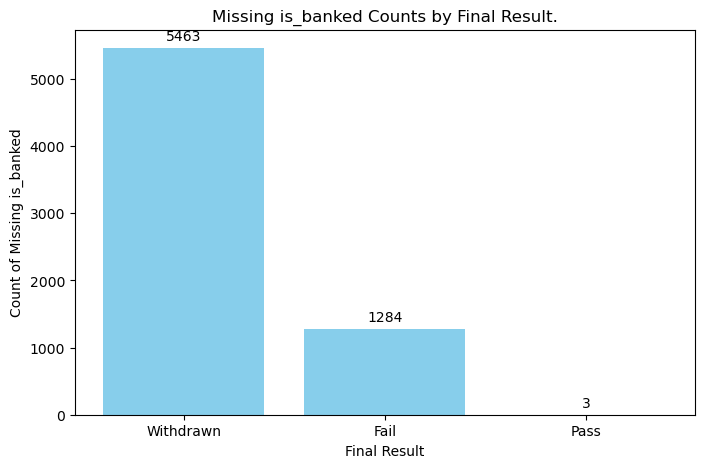

In [548]:
categories = null_is_banked_final_result_counts.index.tolist()
counts = null_is_banked_final_result_counts.values.tolist()

reverse_mapping = {v: k for k, v in final_result_mapping.items()}
labelled_categories = [reverse_mapping[val] for val in categories]

plot_bar_with_annotations(
    categories=labelled_categories,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count of Missing is_banked',
    title='Missing is_banked Counts by Final Result.',
)

In [549]:
student_combined_df['is_banked'] = student_combined_df['is_banked'].fillna(0)

### Weighted Score

The students who have null values for `weighted_score` have not submitted any assignments. We can replace the null values with 0s.

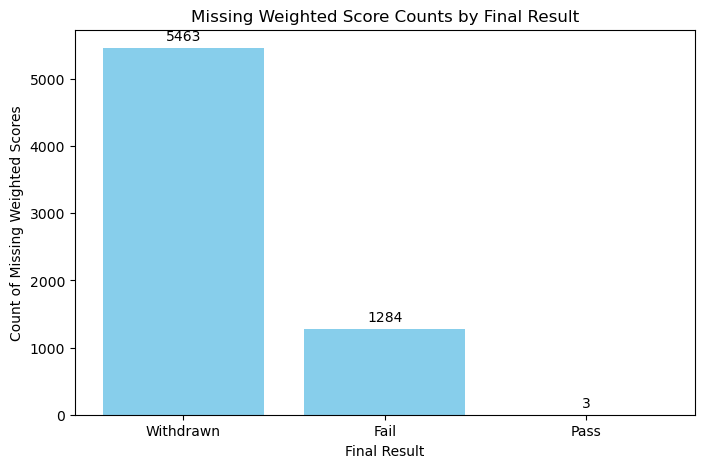

In [550]:
# Get counts of missing weighted_score by 'final_result'.
missing_weighted_score_per_final_result = student_combined_df[student_combined_df['weighted_score'].isna()]['final_result'].value_counts().sort_index()
categories = missing_weighted_score_per_final_result.index.tolist()
counts = missing_weighted_score_per_final_result.values.tolist()

plot_bar_with_annotations(
    categories=labelled_categories,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count of Missing Weighted Scores',
    title='Missing Weighted Score Counts by Final Result',
)

A vast majority of the students with null weighted scores have withdrawn (about 81% of null rows) or failed (about 19% of null rows). This leaves three students who have passed but their weighted scores are missing from the dataset. This is most likely a mistake from the dataaset or the system was unable to register the scores for these students.

- We will take the mean weighted score for students who have passed and impute it to the missing weighted scores for passed students.
- For Failed/Withdrawen students, we will asign their score to zero as according the the data specs, if the student does not submit the assessment, no result is recorded. The final exam submissions is missing, if the result of the assessments is not stored in the system. 

In [ ]:
# Calculate and store the mean pass score.
mean_pass_score = round(student_combined_df[(student_combined_df['final_result'] == 2) & (student_combined_df['weighted_score'].notna())]['weighted_score'].mean(), 2)

# Impute the mean pass score to the three students who have passed but have null weighted scores.
student_combined_df.loc[(student_combined_df['final_result'] == 2) & (student_combined_df['weighted_score'].isna()),'weighted_score'] = round(mean_pass_score, 2)

In [552]:
# For the Failed/Withdrawn students, the weighted score will be set to 0.
student_combined_df['weighted_score'] = student_combined_df['weighted_score'].fillna(0)

### Late Rate and Fail Rate

Students with missing values for their late submission and fail rates likely did not submit any assignments. Therefore, these NaN values can be replaced with 1.00, indicating a 100% late submission rate.

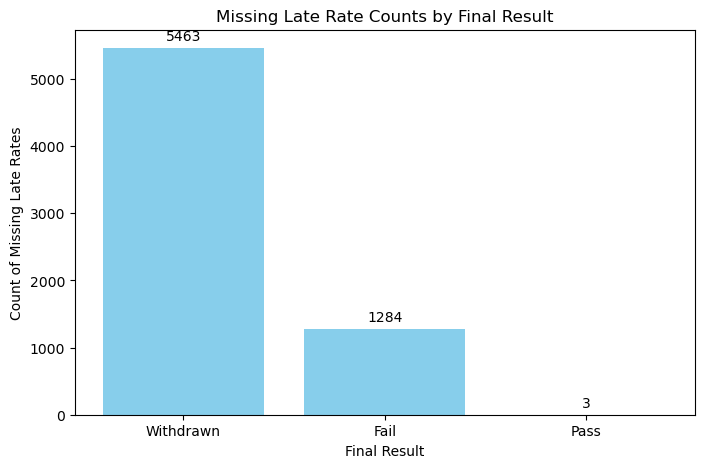

In [553]:
# Get counts of missing late_rate by 'final_result'.
missing_late_rate_per_final_result = student_combined_df[student_combined_df['late_rate'].isna()]['final_result'].value_counts().sort_index()
categories = missing_late_rate_per_final_result.index.tolist()
counts = missing_late_rate_per_final_result.values.tolist()

plot_bar_with_annotations(
    categories=labelled_categories,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count of Missing Late Rates',
    title='Missing Late Rate Counts by Final Result',
)

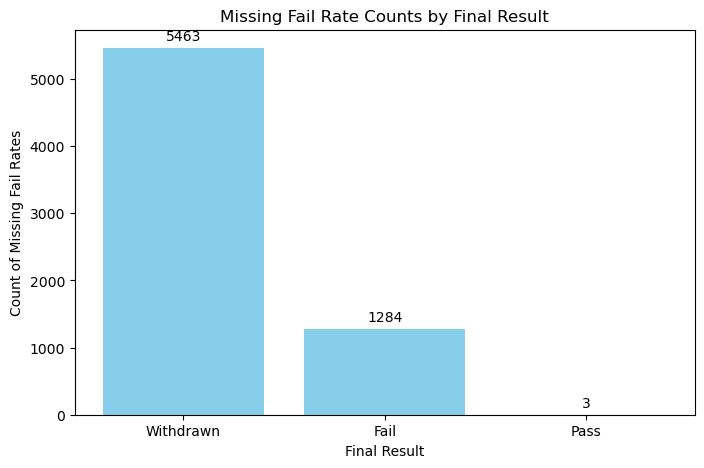

In [554]:
# Get counts of missing fail_rate by 'final_result'.
missing_fail_rate_per_final_result = student_combined_df[student_combined_df['fail_rate'].isna()]['final_result'].value_counts().sort_index()
categories = missing_fail_rate_per_final_result.index.tolist()
counts = missing_fail_rate_per_final_result.values.tolist()

plot_bar_with_annotations(
    categories=labelled_categories,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count of Missing Fail Rates',
    title='Missing Fail Rate Counts by Final Result',
)

Both the `late_rate` and `fail_rate` columns have missing values in the same rows. We will handle these missing values using a similar approach as we did for the `weighted_score`.

* For students who passed but have missing `late_rate` and `fail_rate`, we will impute these values with the average rates calculated from all passed students.
* For the remaining students who either failed or withdrew, we will assign a value of 1 for both `late_rate` and `fail_rate`. This is because these students also lack weighted scores, indicating that their late and fail rates could not be calculated. Assigning a value of 1 reflects that these students either did not submit, failed, or submitted all assessments late.

In [555]:
student_combined_df['highest_education'].unique()

array([3, 2, 1, 4, 0])

In [556]:
### Late Rate ###
# Impute mean late_rate for passed students missing it.
mean_pass_late_rate = round(student_combined_df.loc[(student_combined_df['final_result'] == 2) & (student_combined_df['late_rate'].notna()), 'late_rate'].mean(), 2)
student_combined_df.loc[(student_combined_df['final_result'] == 2) & (student_combined_df['late_rate'].isna()), 'late_rate'] = mean_pass_late_rate

### Fail Rate ###
# Impute mean fail_rate for passed students missing it.
mean_pass_fail_rate = round(student_combined_df.loc[(student_combined_df['final_result'] == 2) & (student_combined_df['fail_rate'].notna()), 'fail_rate'].mean(), 2)
student_combined_df.loc[(student_combined_df['final_result'] == 2) & (student_combined_df['fail_rate'].isna()), 'fail_rate'] = mean_pass_fail_rate

In [557]:
# Fill remaining missing late_rate and fail_rate with 0.
student_combined_df['late_rate'] = student_combined_df['late_rate'].fillna(1)
student_combined_df['fail_rate'] = student_combined_df['fail_rate'].fillna(1)

### IMD Band Imputation (Bayesian Approach)

The IMD band is a key feature in the dataset as it provides an indication of a student's socio-economic background, which may significantly influence their likelihood of dropping out. Based on our hypothesis, certain demographic groups, particularly those defined by age, IMD level, region, and education, may be disproportionately affected by dropout risk. Therefore, ensuring the accuracy of this field is critical for effective modelling. Rather than relying on simpler imputation methods like mean, median, or mode, we will apply a Bayesian Ridge regression model to predict missing IMD values. This approach leverages patterns in related features to generate more reliable and context-aware imputations.

In [558]:
student_combined_df['imd_band'].value_counts()

imd_band
20-30%     3679
30-40%     3566
10-20      3541
0-10%      3338
40-50%     3278
50-60%     3152
60-70%     2925
70-80%     2902
80-90%     2792
90-100%    2563
Name: count, dtype: int64

In [559]:
imd_mapping = {
    '0-10%': 0,
    '10-20%': 1,
    '20-30%': 2,
    '30-40%': 3,
    '40-50%': 4,
    '50-60%': 5,
    '60-70%': 6,
    '70-80%': 7,
    '80-90%': 8,
    '90-100%': 9
}
student_combined_df['imd_band'] = student_combined_df['imd_band'].map(imd_mapping)

We first encode `imd_band` to ordinal values.

In [560]:
student_combined_df[student_combined_df['imd_band'].isnull()].head(5)

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,is_banked,weighted_score,late_rate,fail_rate
9,AAA,2013J,53025,-179.0,NaN,268,1,North Region,4,NaN,2,0,60,0,2,3158.0,0.0,79.0,0.0,0.00
17,AAA,2013J,71361,-130.0,NaN,268,1,Ireland,3,NaN,1,0,60,0,2,2327.0,0.0,79.7,0.0,0.00
18,AAA,2013J,74372,-50.0,NaN,268,1,East Anglian Region,2,NaN,1,0,150,0,1,116.0,0.0,32.8,0.5,0.25
28,AAA,2013J,104476,-109.0,NaN,268,1,Ireland,4,NaN,1,0,60,0,2,4777.0,0.0,78.9,0.4,0.00
34,AAA,2013J,114017,-29.0,NaN,268,0,North Region,4,NaN,1,0,60,0,2,757.0,0.0,72.3,0.0,0.00


There are null values that needed to be imputed.

In [561]:
imd_counts = student_combined_df.groupby('region')['imd_band'].value_counts(dropna=False)
for (region, imd_band), count in imd_counts.items():
    print(f"Region: {region}, IMD Band: {imd_band}, Count: {count}")

Region: East Anglian Region, IMD Band: 9.0, Count: 418
Region: East Anglian Region, IMD Band: 7.0, Count: 415
Region: East Anglian Region, IMD Band: 4.0, Count: 414
Region: East Anglian Region, IMD Band: 8.0, Count: 407
Region: East Anglian Region, IMD Band: 6.0, Count: 403
Region: East Anglian Region, IMD Band: 5.0, Count: 369
Region: East Anglian Region, IMD Band: 3.0, Count: 365
Region: East Anglian Region, IMD Band: 2.0, Count: 306
Region: East Anglian Region, IMD Band: nan, Count: 165
Region: East Anglian Region, IMD Band: 0.0, Count: 104
Region: East Midlands Region, IMD Band: nan, Count: 310
Region: East Midlands Region, IMD Band: 2.0, Count: 278
Region: East Midlands Region, IMD Band: 3.0, Count: 257
Region: East Midlands Region, IMD Band: 8.0, Count: 253
Region: East Midlands Region, IMD Band: 4.0, Count: 241
Region: East Midlands Region, IMD Band: 5.0, Count: 239
Region: East Midlands Region, IMD Band: 6.0, Count: 236
Region: East Midlands Region, IMD Band: 7.0, Count: 209
Re

#### Baysian Imputation of IMD Band

In [562]:
# Prepare the data.
features = ['region', 'age_band', 'highest_education', 'gender', 'disability', 'final_result']
bayesian_imd_df = student_combined_df[features + ['imd_band']].copy()
bayesian_imd_df = bayesian_imd_df.dropna(subset=features) # Drop rows with missing values in the features

# Separate rows with known and missing imd_band
train_imd_df = bayesian_imd_df[bayesian_imd_df['imd_band'].notnull()]
predict_imd_df = bayesian_imd_df[bayesian_imd_df['imd_band'].isnull()]

# Define columns to encode.
onehot_imd_cols = ['region', 'gender']
ordinal_imd_cols = ['age_band', 'highest_education', 'disability', 'final_result']

# Set up column transformer.
preprocessor = ColumnTransformer(transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_imd_cols),
        ('ordinal', OrdinalEncoder(), ordinal_imd_cols)
    ])

# Fit on training data and transform both train and predict sets.
X_train = preprocessor.fit_transform(train_imd_df[features])
X_predict = preprocessor.transform(predict_imd_df[features])
y_train = train_imd_df['imd_band'].astype(float)

# Initiate and fit the bayesian model.
bayesian_imd_model = BayesianRidge()
bayesian_imd_model.fit(X_train, y_train)

predicted_imd = bayesian_imd_model.predict(X_predict).round().clip(0, 9).astype(int) # Predict missing imd values.
student_combined_df.loc[student_combined_df['imd_band'].isnull(), 'imd_band'] = predicted_imd # Impute the imd predictions into the summarised df.

In [563]:
student_combined_df[student_combined_df['id_student'] == 386924]

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,is_banked,weighted_score,late_rate,fail_rate
184,AAA,2013J,386924,-192.0,NaN,268,1,Ireland,1,5.0,0,0,120,0,2,164.0,0.0,68.9,0.4,0.0


In [564]:
student_combined_df.isna().sum()

code_module                       0
code_presentation                 0
id_student                        0
date_registration                 0
date_unregistration           22751
module_presentation_length        0
gender                            0
region                            0
highest_education                 0
imd_band                          0
age_band                          0
num_of_prev_attempts              0
studied_credits                   0
disability                        0
final_result                      0
total_clicks                      0
is_banked                         0
weighted_score                    0
late_rate                         0
fail_rate                         0
dtype: int64

---

In [565]:
student_combined_df.to_csv('student_combined_df_cleaned.csv', index=False)

### Split the dataset

It's important to split the dataset before doing serious exploratory analysis as we do not want to peak at the testing data. Any pre-processing and further feature engineering will also be done to the test set with the same parameters as are set for the training set. We'' stratify by code module to make sure that each module is represented equally in both the test and the training sets.

In [ ]:
train, test = train_test_split(student_combined_df, test_size = 0.2, random_state = 42, stratify = student_combined_df['code_module'])

In [ ]:
train_class = train.copy()
test_class = test.copy()

In [ ]:
# Drop unneeded columns
train_class.drop(columns=['id_student'], inplace=True)
train_class.drop(columns=['date_unregistration'], inplace=True)
# Drop columns on assessments
train_class.drop(columns=['weighted_score'], inplace=True)
train_class.drop(columns=['late_rate'], inplace=True)
train_class.drop(columns=['fail_rate'], inplace=True)
train_class.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,is_banked
4414,BBB,2013J,-29.0,268,0,North Western Region,Lower Than A Level,4.0,1,0,60,0,0,20.0,NaN
24849,FFF,2013J,-74.0,268,1,London Region,A Level or Equivalent,8.0,1,0,120,0,2,3348.0,0.0
26263,FFF,2013J,-144.0,268,0,East Anglian Region,Lower Than A Level,1.0,1,0,60,0,3,2219.0,0.0
25634,FFF,2013J,-49.0,268,1,East Midlands Region,A Level or Equivalent,NaN,1,0,120,0,1,218.0,0.0
11056,CCC,2014J,-17.0,269,0,South Region,A Level or Equivalent,10.0,1,0,120,0,0,157.0,0.0


# Univariate analysis: numerical data

In [ ]:
student_combined_df['region'].unique()

array(['East Anglian Region', 'Scotland', 'North Western Region',
       'South East Region', 'West Midlands Region', 'Wales',
       'North Region', 'South Region', 'Ireland', 'South West Region',
       'East Midlands Region', 'Yorkshire Region', 'London Region'],
      dtype=object)

In [ ]:
student_combined_df['highest_education'].unique()

array(['HE Qualification', 'A Level or Equivalent', 'Lower Than A Level',
       'Post Graduate Qualification', 'No Formal quals'], dtype=object)

In [ ]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date_registration,26284.0,-69.546797,49.350940,-422.0,-101.0,-57.000,-29.00,124.0
date_unregistration,8109.0,49.867308,82.793096,-365.0,-2.0,29.000,109.00,444.0
module_presentation_length,26284.0,256.037171,13.172298,234.0,241.0,262.000,268.00,269.0
gender,26284.0,0.550183,0.497485,0.0,0.0,1.000,1.00,1.0
imd_band,22834.0,5.579268,2.759987,1.0,3.0,6.000,8.00,10.0
age_band,26284.0,1.301590,0.473162,1.0,1.0,1.000,2.00,3.0
num_of_prev_attempts,26284.0,0.171017,0.489757,0.0,0.0,0.000,0.00,6.0
studied_credits,26284.0,79.875590,40.989127,30.0,60.0,60.000,120.00,585.0
disability,26284.0,0.098463,0.297945,0.0,0.0,0.000,0.00,1.0
final_result,26284.0,1.253690,0.998351,0.0,0.0,1.000,2.00,3.0


In [ ]:
top5_unreg = train.sort_values(by='date_unregistration', ascending=False).head(5)
top5_unreg

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,is_banked,weighted_score,late_rate,fail_rate
25448,FFF,2013J,586851,-22.0,444.0,268,1,Wales,Lower Than A Level,1.0,1,0,120,0,0,1326.0,0.0,41.00,0.4,0.0
311,AAA,2013J,2391984,-101.0,242.0,268,1,South Region,A Level or Equivalent,10.0,1,0,60,0,0,818.0,0.0,50.90,1.0,0.0
3392,BBB,2013J,556427,-107.0,241.0,268,0,East Midlands Region,A Level or Equivalent,3.0,1,0,60,0,0,141.0,0.0,40.73,0.5,0.0
223,AAA,2013J,603861,-38.0,241.0,268,1,North Region,HE Qualification,NaN,3,0,60,0,0,955.0,0.0,64.00,0.6,0.0
405,AAA,2014J,95755,-80.0,241.0,269,1,South East Region,Lower Than A Level,10.0,1,0,60,0,0,381.0,0.0,12.20,1.0,0.5


There is one case where the student (id_student: 586851) unregisters 444 days after the start of the module, that same module ends by day 268, but the student withdraws much later after the end of the module. This may be mistake in the dataset, most likely a wrong unregistration date.

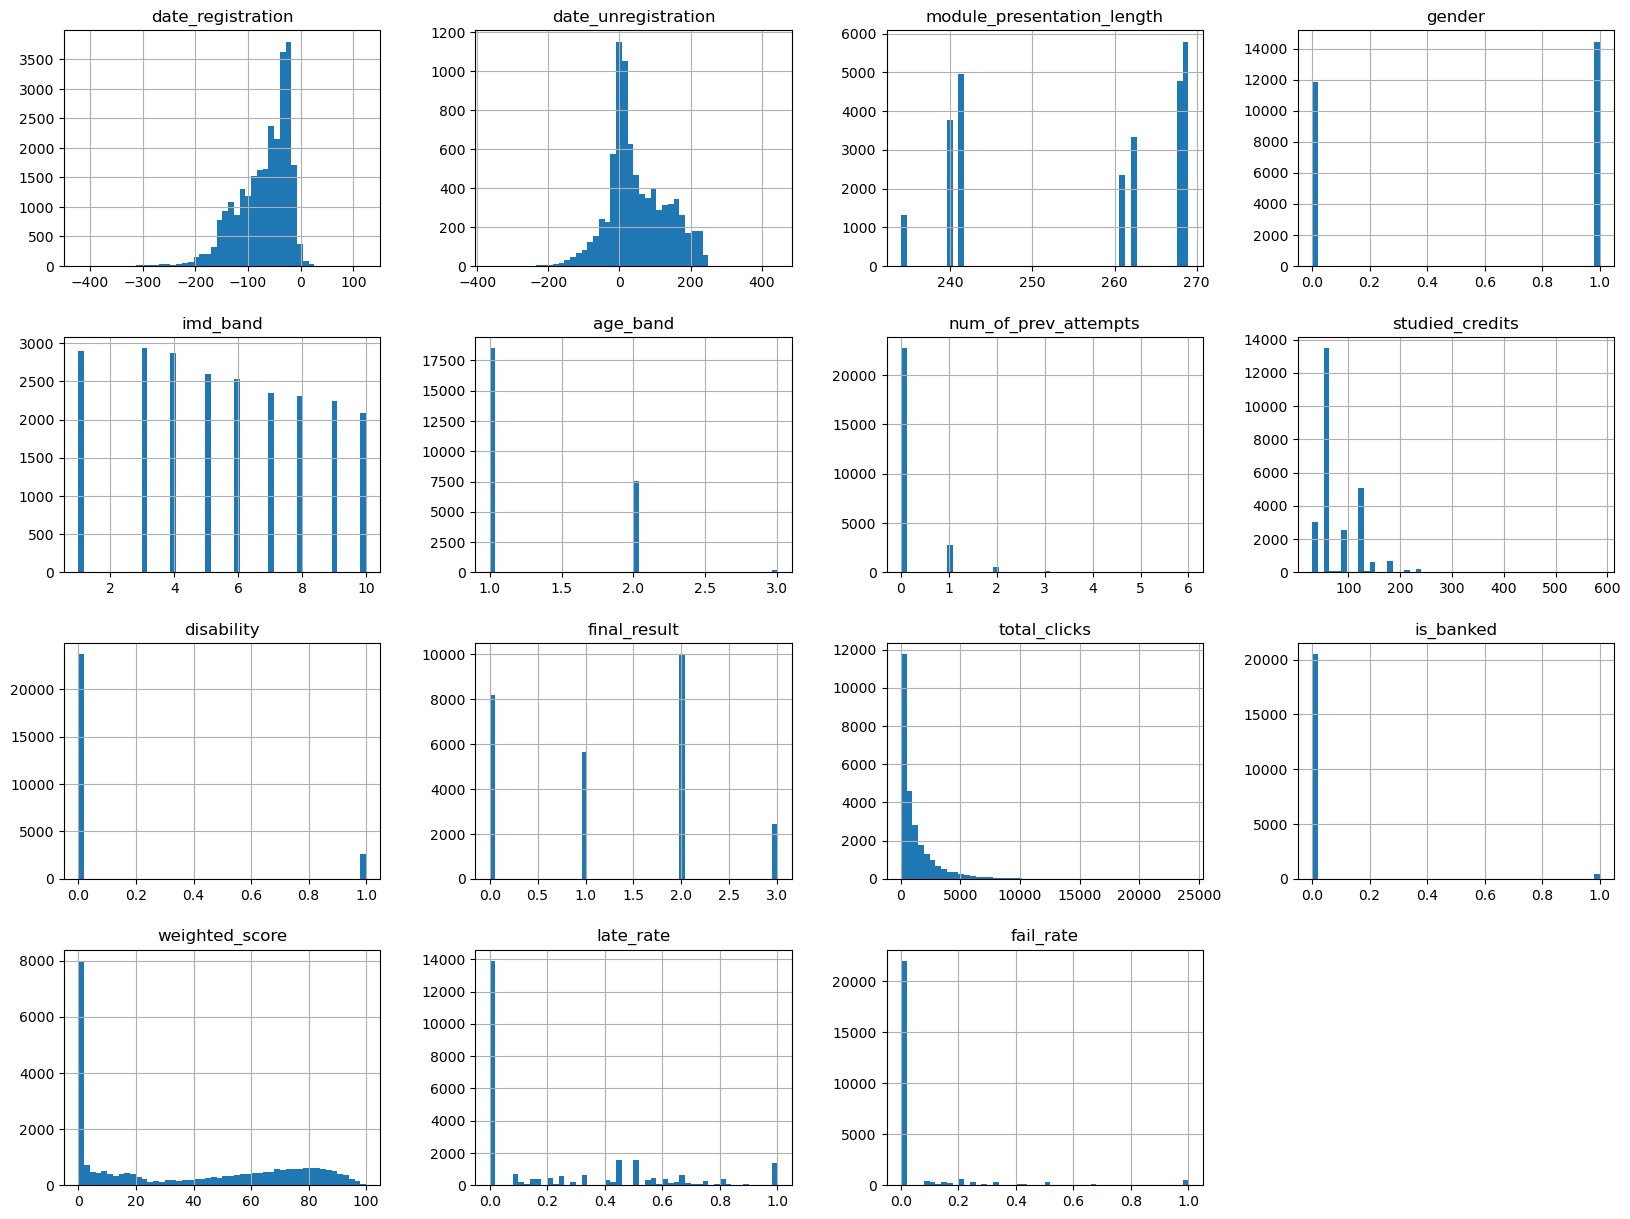

In [ ]:
train.hist(bins=50, figsize=(20, 15))
plt.show()

There's a lot of skewed variables in this dataset. Something to keep in mind when using linear models as these assume normal distributions.

We can see the target variable has two peaks and is not normally distributed, but it doesn't have any outliers. We may wish to transform the target at some point to improve our models. This notebook shows very basic analysis though, so we will not be doing this, but it's something to keep in mind when using certain models (like the linear regression that assumes the distributions are normal).

## Correlation Matrix

In [ ]:
# plt.figure(figsize=(6,4))
# sns.heatmap(train.corr(), annot=True, cmap="coolwarm")

---